In [1]:
import dotenv

dotenv.load_dotenv()

True

In [2]:
from langgraph.checkpoint.memory import MemorySaver

# 메모리 저장소 생성
memory = MemorySaver()

In [3]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

In [4]:
########## 1. 상태 정의 ##########
# 상태 정의
class State(TypedDict):
    # 메시지 목록 주석 추가
    messages: Annotated[list, add_messages]
    dummy_data: Annotated[str, "dummy"]


In [6]:
########## 2. 도구 정의 및 바인딩 ##########
# 도구 초기화
tool = TavilySearchResults(max_results=3)
tools = [tool]

# LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.,)

# 도구와 LLM 결합
llm_with_tools = llm.bind_tools(tools)

In [7]:
########## 3. 노드 추가 ##########
# 챗봇 함수 정의
def chatbot(state: State):
    # 메시지 호출 및 반환
    return {"messages": [llm_with_tools.invoke(state["messages"])],
            "dummy_data": "[chatbot] 호출, dummy data"
            }

In [8]:
# 상태 그래프 생성
graph_builder = StateGraph(State)

In [9]:
# 도구 노드 생성 및 추가
tool_node = ToolNode(tools=[tool])

In [10]:
# 챗봇 노드 추가
graph_builder.add_node("chatbot", chatbot)

In [11]:
# 도구 노드 추가
graph_builder.add_node("tools", tool_node)

In [12]:
# 조건부 엣지
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,)

In [13]:
########## 4. 엣지 추가 ##########

# tools > chatbot
graph_builder.add_edge("tools", "chatbot")

# START > chatbot
graph_builder.add_edge(START, "chatbot")

# chatbot > END
graph_builder.add_edge("chatbot", END)

In [14]:
# 그래프 빌더 컴파일
graph = graph_builder.compile(checkpointer=memory)

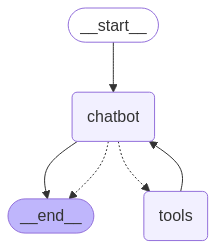

In [15]:
graph

In [16]:
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-tag"] # Tag
)

In [33]:
# 첫 질문
question = (
    "2024년 노벨 화학상 관련 뉴스를 알려주세요."
)

In [34]:
_input = State(messages=[("user", question)], dummy_data="테스트트")

In [19]:
for event in graph.stream(input=_input, config=config):
    for key, value in event.items():
        print(f"\n[   {key}   ]\n")
        if "messages" in value:
            messages = value["messages"]
            value["messages"][-1].pretty_print()


[   chatbot   ]

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_t8HqlDuUTvd0M9a7DDujo2l1)
 Call ID: call_t8HqlDuUTvd0M9a7DDujo2l1
  Args:
    query: 2024 Nobel Prize in Literature news

[   tools   ]

================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "The Nobel Prize in Literature 2024 - Press release - NobelPrize.org", "url": "https://www.nobelprize.org/prizes/literature/2024/press-release/", "content": "The Nobel Prize in Literature for 2024 is awarded to the South Korean author Han Kang, for her intense poetic prose that confronts historical traumas.", "score": 0.9344013}, {"title": "International Writing Program participant wins 2024 Nobel Prize in ...", "url": "https://now.uiowa.edu/news/2024/10/international-writing-program-participant-wins-2024-nobel-prize-literature", "content": "The 2024 Nobel Prize in Literature has been

In [20]:
graph.channels.keys()

dict_keys(['messages', 'dummy_data', '__start__', 'chatbot', 'tools', 'branch:__start__:__self__:chatbot', 'branch:__start__:__self__:tools', 'branch:chatbot:__self__:chatbot', 'branch:chatbot:__self__:tools', 'branch:tools:__self__:chatbot', 'branch:tools:__self__:tools', 'start:chatbot', 'branch:chatbot:tools_condition:tools'])

In [38]:
event

{'chatbot': {'dummy_data': '[chatbot] 호출, dummy data'}}

In [37]:
for event in graph.stream(input=_input, config=config):
    for key, value in event.items():
        print(f"\n[   {key}   ]\n")
        if "messages" in value:
            messages = value["messages"]
            value["messages"][-1].pretty_print()

BadRequestError: Error code: 400 - {'error': {'message': "An assistant message with 'tool_calls' must be followed by tool messages responding to each 'tool_call_id'. The following tool_call_ids did not have response messages: call_pZLju6mKHtdbCPizY0YRTAoh", 'type': 'invalid_request_error', 'param': 'messages.[11].role', 'code': None}}

In [27]:
for event in graph.stream(
    input=_input,
    config=config,
    output_keys=["dummy_data"],  # messages 를 추가해 보세요!
):
    for key, value in event.items():
        # key 는 노드 이름
        print(f"\n[ {key} ]\n")

        # dummy_data 가 존재하는 경우
        if value:
            # value 는 노드의 출력값
            print(value.keys())
            # dummy_data key 가 존재하는 경우
            if "dummy_data" in value:
                print(value["dummy_data"])

BadRequestError: Error code: 400 - {'error': {'message': "An assistant message with 'tool_calls' must be followed by tool messages responding to each 'tool_call_id'. The following tool_call_ids did not have response messages: call_pZLju6mKHtdbCPizY0YRTAoh", 'type': 'invalid_request_error', 'param': 'messages.[11].role', 'code': None}}

In [ ]:
for event in graph.stream({"messages": [("user", question)]}, config=config):
    for value in event.values():
        value["messages"][-1].pretty_print()

================================== Ai Message ==================================

반갑습니다, 방승욱님! 모두의연구소에서 퍼실리테이터로 근무하시다니, 굉장히 흥미로운 역할이네요. 어떤 종류의 프로젝트를 진행하고 계신가요?


In [19]:
question = (
    "내 이름이 뭐라고 했지? 내 직업과 이름을 정리해서 다시 알려줘"
)

result = graph.invoke({"messages": [("user", question)]}, config=config)

In [27]:
result["messages"][-1].pretty_print()

================================== Ai Message ==================================

당신의 이름은 **방승욱**이며, 현재 **모두의연구소**에서 **퍼실리테이터**로 근무하고 있습니다.


In [33]:
result["messages"][-1]

AIMessage(content='당신의 이름은 **방승욱**이며, 현재 **모두의연구소**에서 **퍼실리테이터**로 근무하고 있습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 192, 'total_tokens': 229, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'stop', 'logprobs': None}, id='run-5c1d68ee-a6bc-483d-b48f-5a9b8a7091a7-0', usage_metadata={'input_tokens': 192, 'output_tokens': 37, 'total_tokens': 229, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [34]:
result["messages"][-1].content

'당신의 이름은 **방승욱**이며, 현재 **모두의연구소**에서 **퍼실리테이터**로 근무하고 있습니다.'

In [39]:
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
)

In [40]:
question = (
    "내 이름이 뭐라고 했지? 내 직업과 이름을 정리해서 다시 알려줘"
)

result = graph.invoke({"messages": [("user", question)]}, config=config)

In [41]:
result["messages"][-1].content

'당신의 이름은 **방승욱**이며, 직업은 **퍼실리테이터**입니다. 현재 **모두의연구소**에서 근무하고 있습니다.'

In [49]:
config1 = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
)


config2 = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "2"},  # 스레드 ID 설정
)

In [39]:
# 이전에 저장된 config 확인

graph.get_state(config) # 전부 확인
graph.get_state(config).config # thread id만 확인

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efffe13-60db-607b-801f-faef52892005'}}

In [42]:
graph.get_state(config).next

('chatbot',)